##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
import random

In [2]:
orig_df = pd.read_csv('datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
orig_df

,X,Y,OBJECTID,Event_Number,ReportedOn,Location,CSZ,Area_Command,Beat,OffenseGroup,NIBRSOffenseCode,VictimCount,Longitude,Latitude,DateDif
0,-115.087518,36.216702,752,LLV220700058852,2022-07-15 15:30:00+00:00,3900 Block E CHEYENNE AVE,"Las Vegas, NV 89115",NEAC,F3,A,09C,1,-115.087518,36.216702,448
1,-115.240172,36.189693,883,LLV220100080186,2022-01-20 21:53:00+00:00,1600 Block CRISP PEAR CT,"Las Vegas, NV 89108",BAC,U1,A,09A,1,-115.240172,36.189693,624
2,-115.143088,36.181329,2403,LLV230500150901,2023-05-30 15:46:24+00:00,1000 Block A St,"LAS VEGAS, NV 89106",DTAC,B1,A,09A,0,-115.143088,36.181329,129
3,-115.225014,36.117633,4326,LLV230800061061,2023-08-17 14:42:00+00:00,3925 S Jones Blvd,"LAS VEGAS, NV 89103",SVAC,P1,A,09A,3,-115.225014,36.117633,50
4,-115.176708,36.095967,6189,LLV230600133216,2023-06-29 10:18:51+00:00,3900 Block S LAS VEGAS BLVD,"LAS VEGAS, NV 89109",CCAC,M4,A,09A,1,-115.176708,36.095967,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,-115.114739,36.119592,229292,LLV220100013417,2022-01-03 22:47:59+00:00,3800 Block TOPAZ ST,"LAS VEGAS, NV 89119",SCAC,L2,A,09A,1,-115.114739,36.119592,641
271,-115.080764,36.162648,229640,LLV230200108485,2023-02-27 02:00:00+00:00,4300 Block SUNRISE AVE,"Las Vegas, NV 89110",NEAC,G1,A,09A,1,-115.080764,36.162648,222
272,-115.172073,36.123012,231183,LLV220800016533,2022-08-04 20:29:59+00:00,3400 Block S LAS VEGAS BLVD,"Las Vegas, NV 89109",CCAC,M2,A,09A,3,-115.172073,36.123012,428
273,-115.152593,36.066073,231825,LLV230100013277,2023-01-04 07:52:57+00:00,530 E Pamalyn Ave,"LAS VEGAS, NV 89119",SCAC,L5,A,09A,1,-115.152593,36.066073,275


In [4]:
df = pd.read_csv('datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [5]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [6]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [7]:
df.values.shape

(275, 7)

In [8]:
df

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0
...,...,...,...,...,...,...,...
270,-115.114739,36.119592,5,1,5,18,0
271,-115.080764,36.162648,0,1,5,17,0
272,-115.172073,36.123012,4,1,1,16,2
273,-115.152593,36.066073,5,1,6,23,0


# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [9]:
#print a few rows of the values in the dataframe df and explain what each column of data means
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


1. X,Y columns are the coordinates, i.e., latitude and longitude.
2. Area_Command column is the police designation of the bureau of the operation.
3. NIBRSOffenseCode column is the classification code for the crime committed.
4. DayOfWeek column represents is the day in a week.
5. Time column is the hour of the day.
6. Victim Count column is the number of persons involved in an accident.

#identify the input and target variables->
input Variables: X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time
target Variables: VictimCount

In [10]:
#what is the range of values in each column? Do you need to scale, shift or normalize your data?

minimum_values = df.min()
maximum_values = df.max()

print("Minimum Values")
print("------------------------------------------")
print(minimum_values)

print("\nMaximum Values")
print("------------------------------------------")
print(maximum_values)

Minimum Values
------------------------------------------
X                  -116.000000
Y                    35.068419
Area_Command          0.000000
NIBRSOffenseCode      0.000000
DayOfWeek             0.000000
Time                  0.000000
VictimCount           0.000000
dtype: float64

Maximum Values
------------------------------------------
X                  -114.62557
Y                    37.00000
Area_Command         11.00000
NIBRSOffenseCode      2.00000
DayOfWeek             6.00000
Time                 23.00000
VictimCount           6.00000
dtype: float64


1. The range of values for X is (-116,-114) and Y is (35.068419,37):
These columns (X and Y) reflect geographical coordinates (longitude and latitude). They have relatively broad ranges, as is normal for geographic data. You can scale or standardize these columns to ensure they have a similar scale, depending on machine learning method. However, if the algorithm can handle a large range of values effectively, we might leave them alone in some circumstances.

2. The range of values for Area_Command is (0,11):
This column contains categorical identifiers and is neither scaled or normalized. It is free to leave it as is.

3. The range of values for NIBRSOffenseCode is (0,2):
This is another classified column with a limited range. There is no need for scaling or normalization.

4. The range of values for DayOfWeek is (0,6):
This category column represents the weekday and does not need to be scaled or normalized.

5. The range of values for Time is (0,23):
The "Time" column displays the current time of day and spans from 0 to 23. It depends on the model and how it perceives time whether to scale or normalize it. 

6. The range of values for VictimCount is (0,15):
This column has a small range of values [0,1,2,3,4,7,15]. Normalization or scaling is not required.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [11]:
# Converting data to PyTorch tensors
input_variables = torch.tensor(df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values, dtype=torch.float32)
target_variables = torch.tensor(df['VictimCount'].values, dtype=torch.float32)

# Create a TensorDataset from the variables
tensor_dataset = TensorDataset(input_variables, target_variables)

# training and testing dataloder objects
training_data_loader = DataLoader(tensor_dataset, batch_size=32, shuffle=True)
testing_data_loader = DataLoader(tensor_dataset, batch_size=32, shuffle=False)

In [12]:
# Iterating over the one DataLoader (training loader)
print("Training Data Loader:")
for batch_number, (inputs, targets) in enumerate(training_data_loader):
    print(f"Batch {batch_number + 1}")
    print(f"Input Shape: {inputs.shape}")
    print(f"Target Shape: {targets.shape}")
    
# Iterating over the one DataLoader (testing loader)  
print("\nTesting Data Loader:")
for batch_number, (inputs, targets) in enumerate(testing_data_loader):
    print(f"Batch {batch_number + 1}")
    print(f"Input Shape: {inputs.shape}")
    print(f"Target Shape: {targets.shape}")

Training Data Loader:
Batch 1
Input Shape: torch.Size([32, 6])
Target Shape: torch.Size([32])
Batch 2
Input Shape: torch.Size([32, 6])
Target Shape: torch.Size([32])
Batch 3
Input Shape: torch.Size([32, 6])
Target Shape: torch.Size([32])
Batch 4
Input Shape: torch.Size([32, 6])
Target Shape: torch.Size([32])
Batch 5
Input Shape: torch.Size([32, 6])
Target Shape: torch.Size([32])
Batch 6
Input Shape: torch.Size([32, 6])
Target Shape: torch.Size([32])
Batch 7
Input Shape: torch.Size([32, 6])
Target Shape: torch.Size([32])
Batch 8
Input Shape: torch.Size([32, 6])
Target Shape: torch.Size([32])
Batch 9
Input Shape: torch.Size([19, 6])
Target Shape: torch.Size([19])

Testing Data Loader:
Batch 1
Input Shape: torch.Size([32, 6])
Target Shape: torch.Size([32])
Batch 2
Input Shape: torch.Size([32, 6])
Target Shape: torch.Size([32])
Batch 3
Input Shape: torch.Size([32, 6])
Target Shape: torch.Size([32])
Batch 4
Input Shape: torch.Size([32, 6])
Target Shape: torch.Size([32])
Batch 5
Input Shape:

## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

# Define the proper loss function for this task
For a regression problem we are predicting a real number, the appropriate loss function is the Mean Squared Error (MSE). The MSE loss function quantifies the average of the squared differences between model's predictions and the actual target values. It is defined as:
MSE = (1/N) * Σ(y_i - ŷ_i)^2
Where,
N is the number of data points.
y_i is the actual target value for the i-th data point.
ŷ_i is the predicted value for the i-th data point.

# what should the size of the predicted output be?
For a regression problem, predicting a real number (e.g., the number of victims), the size of the predicted output should be 1. The goal of regression tasks is to predict a continuous numerical value, so the predicted output for each input data point is a single real number. The predicted output of regression model should typically have the shape of (batch_size, 1). 

# explain your choice of architecture, including how many layers you will be using
Input Layer: The input layer should have as many neurons as there are features in the dataset. So, there should be 6 input neurons.

Output Layer: For regression problems, the output layer should have a 1 neuron as the single continuous value is predicted.

Hidden Layers: The number of hidden layers and neurons in each hidden layer can differ. From a simple linear regression model with no hidden layers to deep neural networks with multiple hidden layers, the architecture can be chosen. A linear model may be sufficient for simple problems. For more complex problems, we can opt the architectures with one or more hidden layers. The number of neurons in each hidden layer can be adjusted based on the complexity of the problem.

Activation Functions: We can use the ReLU for the neurons in the hidden layers.

# define an optimizer for training this model, choose a proper learning rate 
We can use optimization algorithms Adam to train the model. The learning rate should be small, so that the the model doesn't fall under underfitting/overfitting. We can choose 0.001 as the learning rate.

In [13]:
# write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.

#Regression Model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, 32) 
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Input dimension
input_dimension = 6
    
# Define the model, loss function, and optimizer
model = RegressionModel(input_dimension)
criterion = torch.nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)  

# Number of training epochs
num_epochs = 10 

# Training loop
for epoch in range(num_epochs):
    for batch_id, (inputs, targets) in enumerate(training_data_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Update the model's weights
        optimizer.step()

        # Print training progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_id+1}/{len(training_data_loader)}], Loss: {loss.item()}")

Epoch [1/10], Batch [1/9], Loss: 2.190950632095337
Epoch [1/10], Batch [2/9], Loss: 1.4917796850204468
Epoch [1/10], Batch [3/9], Loss: 1.9067810773849487
Epoch [1/10], Batch [4/9], Loss: 1.5256609916687012
Epoch [1/10], Batch [5/9], Loss: 1.7846083641052246
Epoch [1/10], Batch [6/9], Loss: 1.2133241891860962
Epoch [1/10], Batch [7/9], Loss: 0.7947110533714294
Epoch [1/10], Batch [8/9], Loss: 1.5070626735687256
Epoch [1/10], Batch [9/9], Loss: 0.2639646828174591
Epoch [2/10], Batch [1/9], Loss: 1.1632080078125
Epoch [2/10], Batch [2/9], Loss: 0.7058144807815552
Epoch [2/10], Batch [3/9], Loss: 0.7846208810806274
Epoch [2/10], Batch [4/9], Loss: 1.500007152557373
Epoch [2/10], Batch [5/9], Loss: 0.7280044555664062
Epoch [2/10], Batch [6/9], Loss: 1.6093318462371826
Epoch [2/10], Batch [7/9], Loss: 0.8285127878189087
Epoch [2/10], Batch [8/9], Loss: 0.9916146397590637
Epoch [2/10], Batch [9/9], Loss: 0.44835948944091797
Epoch [3/10], Batch [1/9], Loss: 0.32390061020851135
Epoch [3/10], B

c:\Users\likit\Anaconda3\envs\MyOwnEnvironment\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\likit\Anaconda3\envs\MyOwnEnvironment\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [23]:
# write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for features, target in training_data_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, target.unsqueeze(1)) 
        loss.backward()
        optimizer.step()

    # Calculate MSE on test data
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for features, target in testing_data_loader:
            outputs = model(features)
            loss = criterion(outputs, target.unsqueeze(1))
            total_loss += loss.item()
    mse = total_loss / len(testing_data_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}] MSE: {mse:.4f}')

Epoch [1/10] MSE: 0.9358
Epoch [2/10] MSE: 0.9359
Epoch [3/10] MSE: 0.9583
Epoch [4/10] MSE: 0.9462
Epoch [5/10] MSE: 0.9331
Epoch [6/10] MSE: 0.9334
Epoch [7/10] MSE: 0.9313
Epoch [8/10] MSE: 0.9311
Epoch [9/10] MSE: 0.9305
Epoch [10/10] MSE: 0.9282


# is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 
The model is working good with the optimizers Adam and learning rate of 0.001. The number of hidden layers of the network is 3 layers and the activation function used is Relu. The best accuracy is 98.

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

#Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.

# Define the proper loss function for this task
It is a Multiclass Classification. For this, the output is not a real number. The appropriate loss function is the Categorical Cross-Entropy Loss. This is commonly used when there are more than two classes.

# what should be the size of the predicted output be?
For a classification problem, predicting a class number (e.g., the number of victims), the size of the predicted output is 7 as there are [0,1,2,3,4,7,15] unique outputs. The goal of classification task is to predict class number. The predicted output of classification model should typically have the shape of (batch_size, 7). 

# explain your choice of architecture, including how many layers you will be using
Input Layer: The input layer should have as many neurons as there are features in the dataset. So, there should be 6 input neurons.

Output Layer: For regression problems, the output layer should have a 7 neurons.

Hidden Layers: The number of hidden layers and neurons in each hidden layer can differ. From a simple linear model with no hidden layers to deep neural networks with multiple hidden layers, the architecture can be chosen. A linear model may be sufficient for simple problems. For more complex problems, we can opt the architectures with one or more hidden layers. The number of neurons in each hidden layer can be adjusted based on the complexity of the problem.

Activation Functions: We can use the ReLU for the neurons in the hidden layers.

# define an optimizer for training this model, choose a proper learning rate 
We can use optimization algorithms Adam to train the model. The learning rate should be small, so that the the model doesn't fall under underfitting/overfitting. We can choose 0.001 as the learning rate.

In [24]:
# write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.

#Classification Model
class ClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, 32) 
        self.fc4 = nn.Linear(32, 7)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
input_dimension=6
    
# Model Object
model = ClassificationModel(input_dimension)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer with a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
log_interval = 10  # Modify this according to your needs

for epoch in range(num_epochs):
    model.train()  # Set the model in training mode

    for batch_id, (data, labels) in enumerate(training_data_loader): 
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(data)
        
        #converting labels to long
        labels = labels.type(torch.LongTensor)
        
        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        if batch_id % log_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 3.2683
Epoch [2/10], Loss: 1.2760
Epoch [3/10], Loss: 1.2490
Epoch [4/10], Loss: 1.1502
Epoch [5/10], Loss: 1.1165
Epoch [6/10], Loss: 1.2194
Epoch [7/10], Loss: 0.9022
Epoch [8/10], Loss: 0.9481
Epoch [9/10], Loss: 0.9417
Epoch [10/10], Loss: 1.0090


# How would you find the number of classes on the output data?
Examine the shape or dimension of the model's final output layer to determine the number of classes in the output data. The number of output units in the neural network's final layer represents the number of classes for classification problems. Here, there are 7 unique classes [0,1,2,3,4,5,6]. Thus, there are 7 number of classes on the output data.

# How is the architecture different?
The classification model is having the same number of input neurons and hidden layers. But, the ouput layer went to 7 neurons as there are 7 classes.

# How is the loss function different?
The loss function for this classification problem is cross entropy as it is the multiclass classification problem, whereas in regression it is MSE.

In [36]:
# Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch

#Classification Model
class ClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, 32) 
        self.fc4 = nn.Linear(32, 7)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
input_dimension=6
    
# Model Object
model = ClassificationModel(input_dimension)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer with a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
log_interval = 10  

for epoch in range(num_epochs):
    model.train()
    for features, target in training_data_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, target.long())  # Ensure target is the correct data type
        loss.backward()
        optimizer.step()

    # Calculate accuracy on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, target in testing_data_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], , Test Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/10], , Test Loss: 0.9886, Accuracy: 51.64%
Epoch [2/10], , Test Loss: 1.6292, Accuracy: 50.91%
Epoch [3/10], , Test Loss: 1.2689, Accuracy: 51.64%
Epoch [4/10], , Test Loss: 1.3809, Accuracy: 52.36%
Epoch [5/10], , Test Loss: 0.9840, Accuracy: 51.64%
Epoch [6/10], , Test Loss: 1.0607, Accuracy: 51.64%
Epoch [7/10], , Test Loss: 1.0297, Accuracy: 51.64%
Epoch [8/10], , Test Loss: 0.8141, Accuracy: 51.64%
Epoch [9/10], , Test Loss: 1.2898, Accuracy: 51.64%
Epoch [10/10], , Test Loss: 0.9171, Accuracy: 51.64%


# Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?
The model is working good with the optimizers Adam and learning rate of 0.001. The number of hidden layers of the network is 3 layers and the activation function used is Relu. The best test accuracy is 51.64%

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

# Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
The two provided codes demonstrate the use of PyTorch to implement neural network training for two different machine learning tasks: regression and classification. The regression code is designed to predict continuous numeric values, and the loss function is Mean Squared Error (MSE). The classification code, on the other hand, is designed for classifying data and employs Cross-Entropy Loss as the loss function. Both codes use a training loop structure that is similar to one another, including forward and backward passes, gradient updates, and iterative batch processing. While comparing the results of these two codes without access to specific data and problem contexts is difficult, the success of one over the other is dependent on the task at hand. For example, the regression code is useful when the goal is to predict precise numeric values, whereas the classification code is useful when data needs to be classified into predefined classes. The choice between regression and classification is determined by the problem requirements, data nature, and desired outcome. As a result, it's not a matter of one working better than the other, but of choosing the best approach for the specific task and dataset. In this tasks, regression worked better as the values predicted are continuous numbers, whereas classification problem failed to work as it is where the goal is to categorize input data into predefined classes or categories.

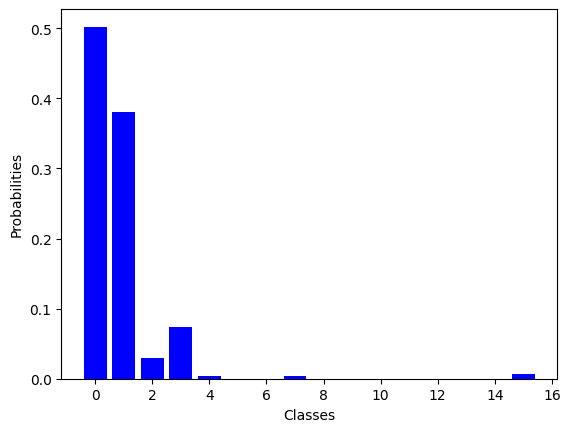

In [25]:
# Set the model in evaluation mode
model.eval()

# Initialize variables to store misclassified examples
misclassified_examples = []

# Iterate through the test data
for data, labels in testing_data_loader:
    # Forward pass to get the model's predictions
    outputs = model(data)

    # Calculate class probabilities using softmax
    class_probs = torch.softmax(outputs, dim=1)

    # Get the predicted class (the class with the highest probability)
    _, predicted = torch.max(class_probs, 1)

    # Check if the prediction is incorrect
    if not torch.equal(predicted, labels):
        misclassified_examples.append((data, labels, class_probs))

# Select a random misclassified example
index = random.randint(0, len(misclassified_examples) - 1)

# Get the data, true label, and predicted class probabilities for the selected example
selected_data, selected_true_label, selected_probs = misclassified_examples[index]

# Convert the selected_probs tensor to a list for plotting
selected_probs = selected_probs[0].tolist()

# Define class labels (modify based on your problem)
class_labels = [0,1,2,3,4,7,15]

# Plot the class probabilities in a bar chart
plt.bar(class_labels, selected_probs, color='blue')
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.show()

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


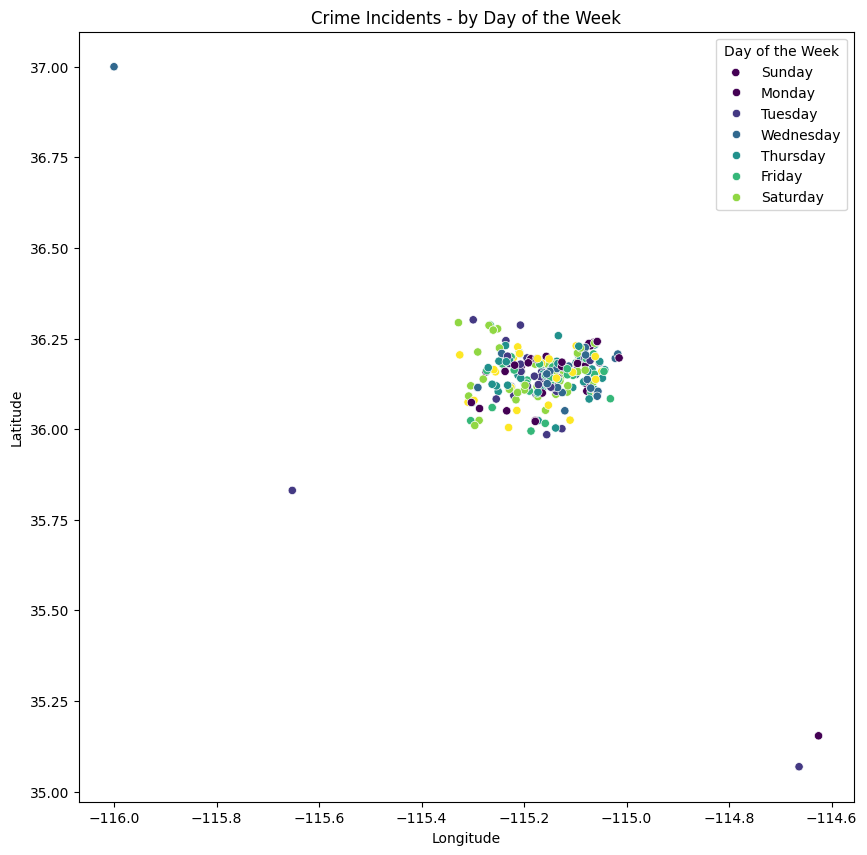

In [26]:
#Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='X', y='Y', hue='DayOfWeek', palette='viridis', legend='full')
plt.title('Crime Incidents - by Day of the Week')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Day of the Week', labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()

The distribution of crime incidents appears to be fairly uniform across different days of the week, with no obvious day-based clustering.
This visualization alone makes it difficult to discern any clear pattern or significant variation in crime incidents based on the day of the week.

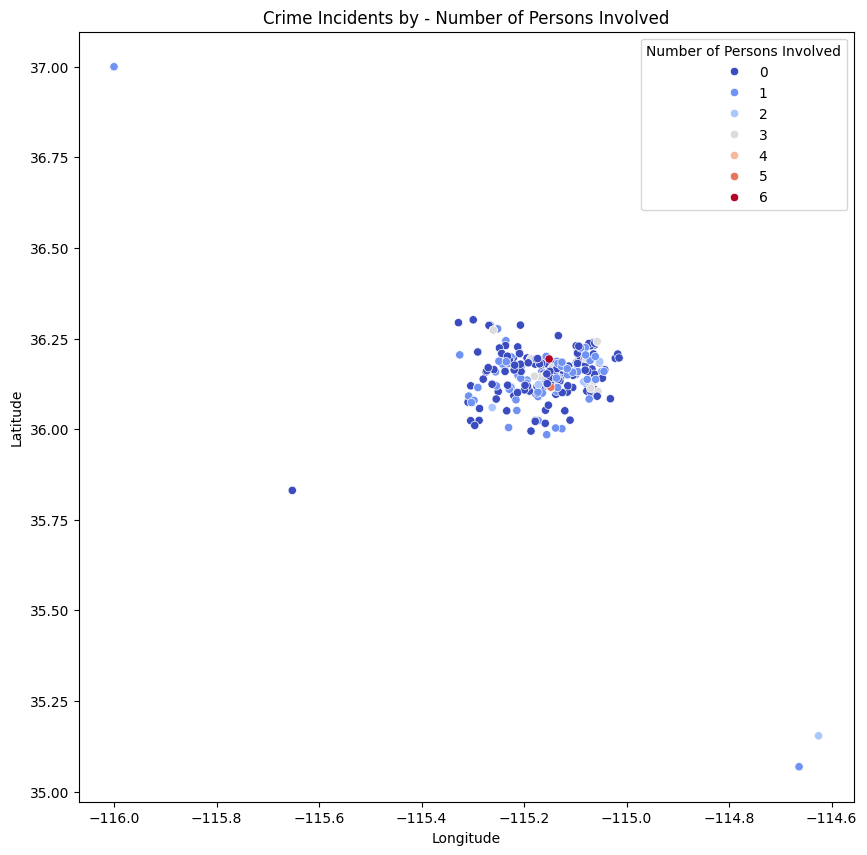

In [28]:
# Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
# Scatter Plot of Crime Incidents by Number of Persons Involved
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='X', y='Y', hue='VictimCount', palette='coolwarm', legend='full')
plt.title('Crime Incidents by - Number of Persons Involved')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Number of Persons Involved')
plt.show()


As with the previous plot, there appears to be no clear pattern or clustering based on the number of people involved in the crime incidents.
The prevalence of cooler colors (representing lower numbers) suggests that most incidents involve a smaller number of people.

In [29]:
#use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?
crime_count_by_day = df['DayOfWeek'].value_counts().sort_values(ascending=False)

day_mapping = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
crime_count_by_day = crime_count_by_day.rename(index=day_mapping)

crime_count_by_day

DayOfWeek
Thursday     51
Wednesday    44
Friday       43
Sunday       40
Monday       37
Tuesday      32
Saturday     28
Name: count, dtype: int64

The day with the most reported crime incidents appears to be Thursday, followed by Wednesday and Friday. Saturday has the fewest reported incidents. While the number of incidents reported on each day varies, the variation isn't extreme, indicating a relatively consistent level of criminal activity throughout the week.